In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pymongo import MongoClient
import os

# Verbindung zu MongoDB herstellen
client = MongoClient('mongodb://localhost:27017/')
db = client['breast_cancer_wisconsin']
collection = db['bereinigte_daten']

# Daten aus MongoDB abrufen
df = pd.DataFrame(list(collection.find()))

#Mapping 'diagnosis' to 'Benign' and 'Malignant'
df['diagnosis'] = df['diagnosis'].map({'B': 'Benign', 'M': 'Malignant'})

In [2]:
# Erstellen der Image-Ordner
output_folder_boxplots = './img/boxplots'
os.makedirs(output_folder_boxplots, exist_ok=True)

output_folder_pairplots = './img/pairplots'
os.makedirs(output_folder_pairplots, exist_ok=True)

output_folder_densityplots = './img/densityplots'
os.makedirs(output_folder_densityplots, exist_ok=True)

output_folder_verteilungsplots = './img/verteilungsplots'
os.makedirs(output_folder_verteilungsplots, exist_ok=True)

output_folder_wahrscheinlichkeitsplots = './img/wahrscheinlichkeitsplots'
os.makedirs(output_folder_wahrscheinlichkeitsplots, exist_ok=True)

In [3]:
#Defining color mapping for 'Benign' and 'Malignant' (because we like pretty things :) ) 
color_map = {'Benign': 'darkturquoise', 'Malignant': 'darkred'}

#Defining the four main metric groups for cleaner visualisation
size_metrics = ['radius_mean', 'area_mean', 'perimeter_mean']
shape_metrics = ['concavity_mean', 'concave points_mean', 'smoothness_mean']
texture_metrics = ['texture_mean', 'texture_worst']
compactness_metrics = ['compactness_mean', 'compactness_worst']

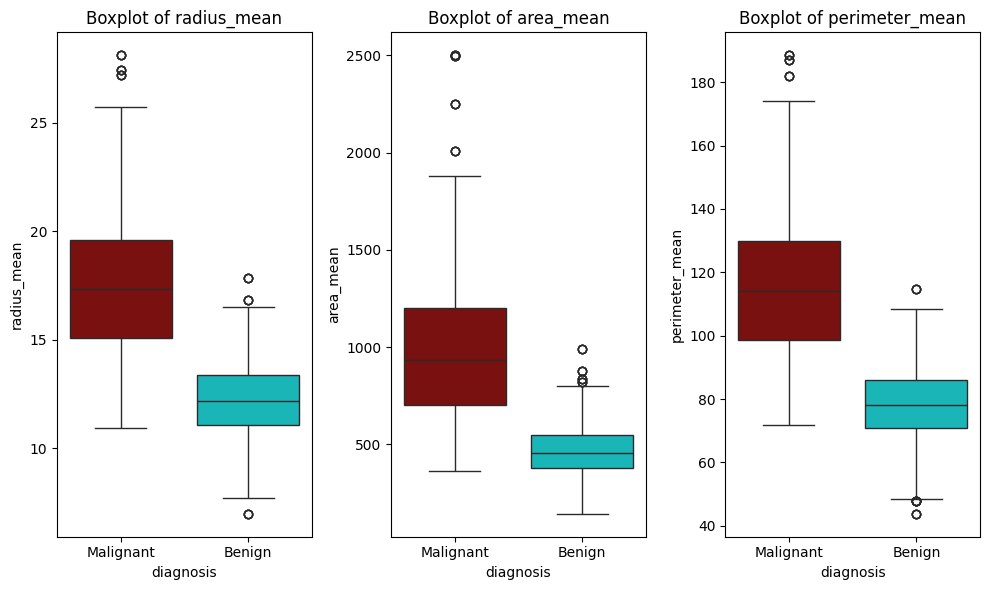

In [11]:
#Size: Boxplots
plt.figure(figsize=(10, 6))
for i, metric in enumerate(size_metrics, 1):
    plt.subplot(1, len(size_metrics), i)
    sns.boxplot(x='diagnosis', y=metric, data=df, 
                hue='diagnosis', 
                dodge=False,  
                palette=color_map)
    plt.title(f"Boxplot of {metric}")
    plt.xlabel("diagnosis")
    plt.ylabel(metric)
plt.tight_layout()

plot_path = os.path.join(output_folder_boxplots, 'Boxplot_size_metrics.png')
plt.savefig(plot_path)

plt.show()

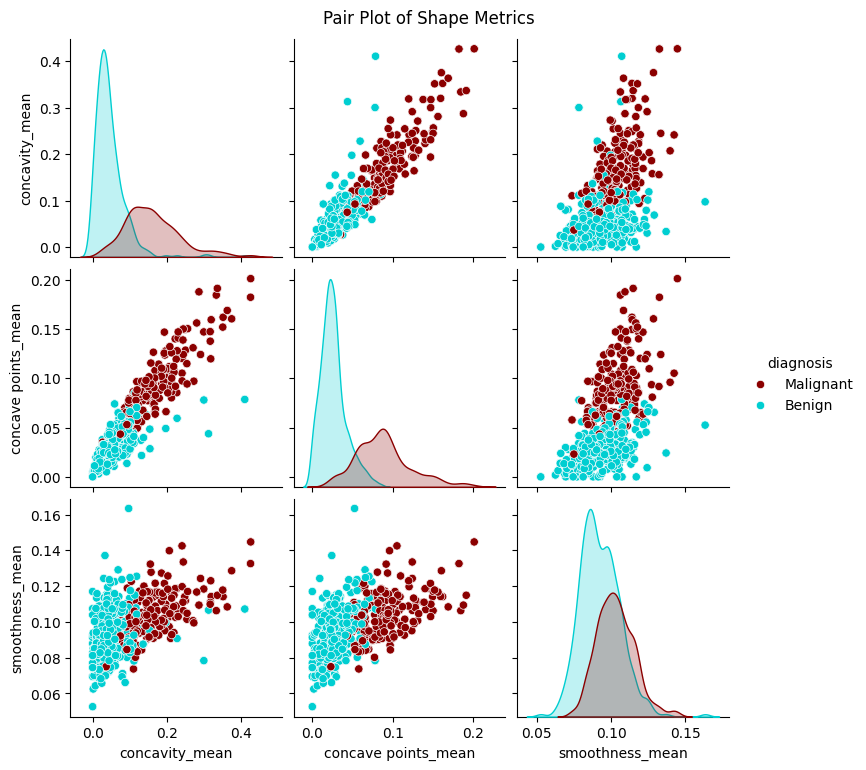

In [12]:
#Shape: Pair Plots 
sns.pairplot(
    df[shape_metrics + ['diagnosis']],
    hue='diagnosis', 
    diag_kind='kde', 
    palette=color_map  
)
plt.suptitle("Pair Plot of Shape Metrics", y=1.02)

plot_path = os.path.join(output_folder_pairplots, 'Pairplots_shape_metrics.png')
plt.savefig(plot_path)

plt.show()

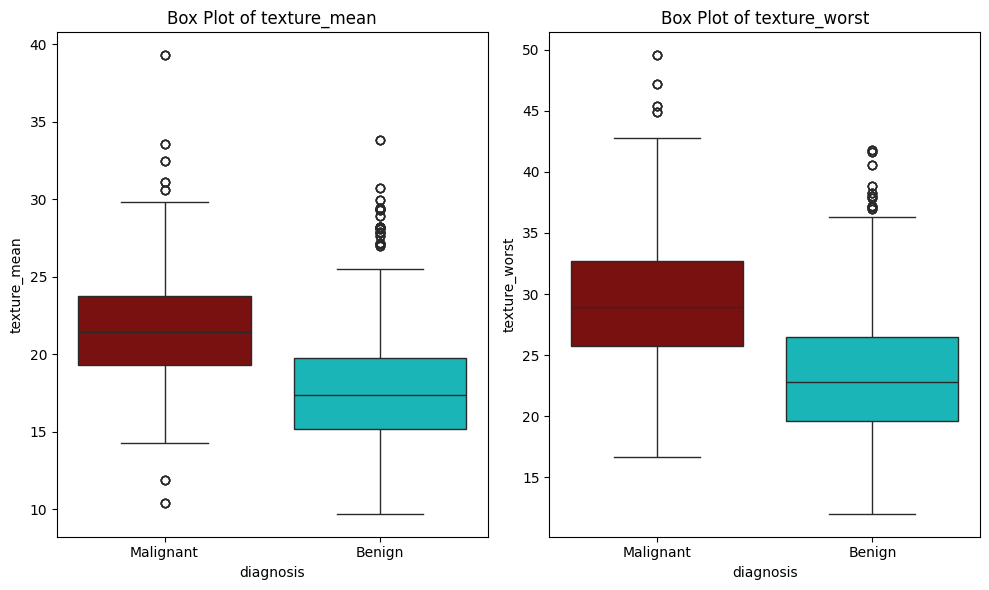

In [13]:
#Texture: Box Plots 
plt.figure(figsize=(10, 6))
for i, metric in enumerate(texture_metrics, 1):
    plt.subplot(1, len(texture_metrics), i)
    sns.boxplot(x='diagnosis', y=metric, data=df, 
                hue='diagnosis', 
                dodge=False,  
                palette=color_map)
    plt.title(f"Box Plot of {metric}")
    plt.xlabel("diagnosis")
    plt.ylabel(metric)
plt.tight_layout()

plot_path = os.path.join(output_folder_boxplots, 'Boxplot_texture_metrics.png')
plt.savefig(plot_path)

plt.show()

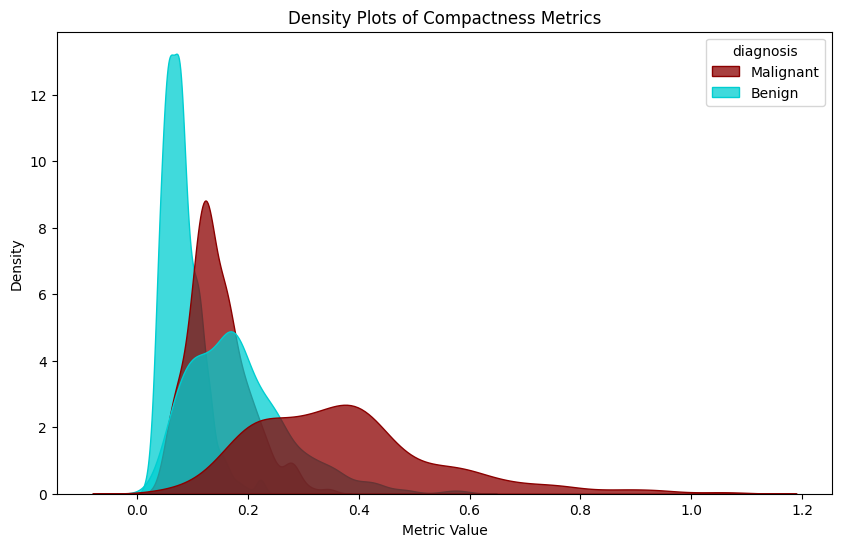

In [14]:
#Compactness: Density Plot 
plt.figure(figsize=(10, 6))
for metric in compactness_metrics:
    sns.kdeplot(
        data=df,
        x=metric,
        hue='diagnosis', 
        fill=True, 
        common_norm=False, 
        alpha=0.75, 
        palette=color_map  
    )
plt.title("Density Plots of Compactness Metrics")
plt.xlabel("Metric Value")
plt.ylabel("Density")

plot_path = os.path.join(output_folder_densityplots, 'Densityplot_compactness_metrics.png')
plt.savefig(plot_path)

plt.show()

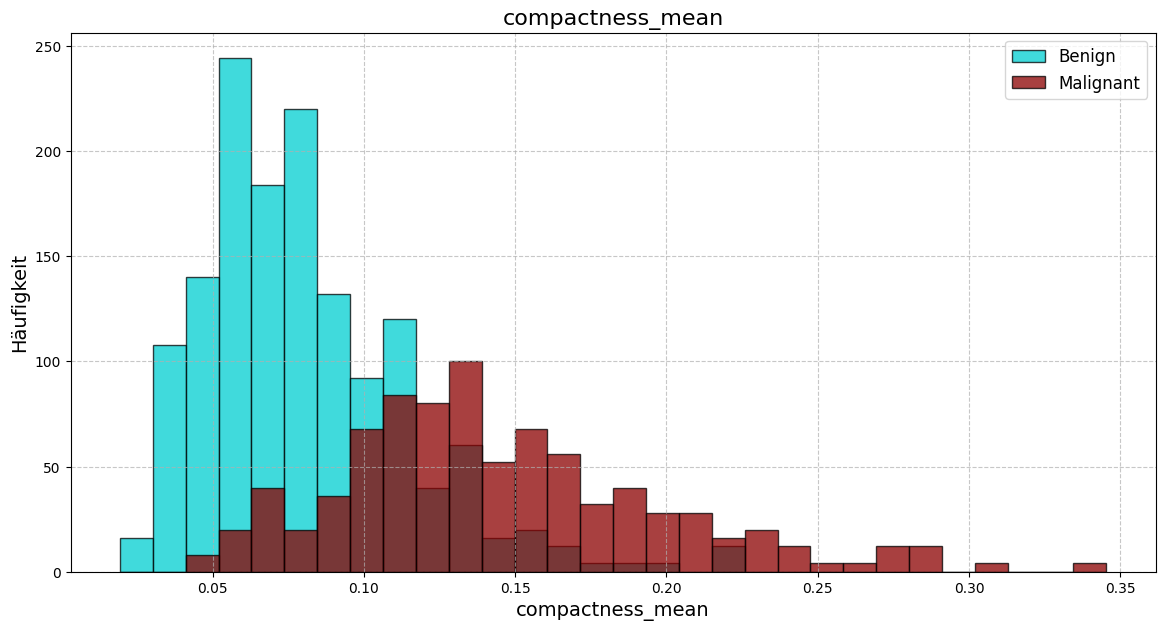

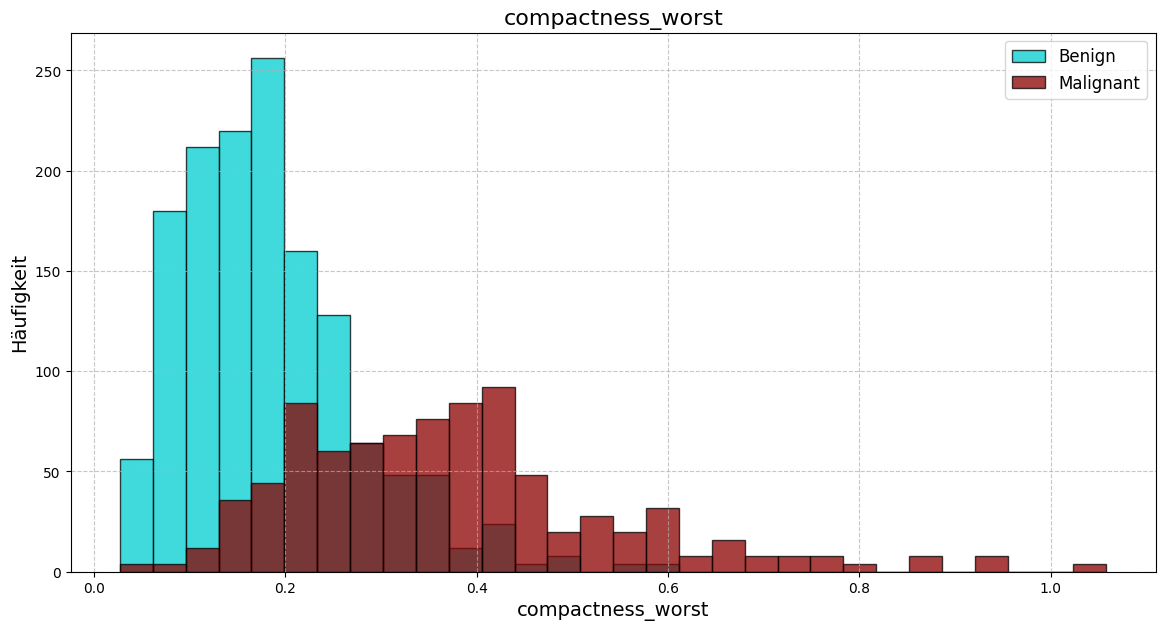

In [8]:
# Erstelle Säulendiagramme für jede Metrik
for metric in compactness_metrics:
        benign_values = df[df['diagnosis'] == 'Benign'][metric]
        malignant_values = df[df['diagnosis'] == 'Malignant'][metric]
        
        # Histogrammbins berechnen
        bins = 30
        bin_edges = np.linspace(min(df[metric]), max(df[metric]), bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        benign_counts, _ = np.histogram(benign_values, bins=bin_edges)
        malignant_counts, _ = np.histogram(malignant_values, bins=bin_edges)

        # Erstelle das Säulendiagramm
        plt.figure(figsize=(14, 7))
        plt.bar(bin_centers, benign_counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.75, label='Benign', color=color_map['Benign'], edgecolor='black')
        plt.bar(bin_centers, malignant_counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.75, label='Malignant', color=color_map['Malignant'], edgecolor='black')
        
        # Diagramm-Details
        plt.title(f"{metric}", fontsize=16)
        plt.xlabel(metric, fontsize=14)
        plt.ylabel('Häufigkeit', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
        plt.close()

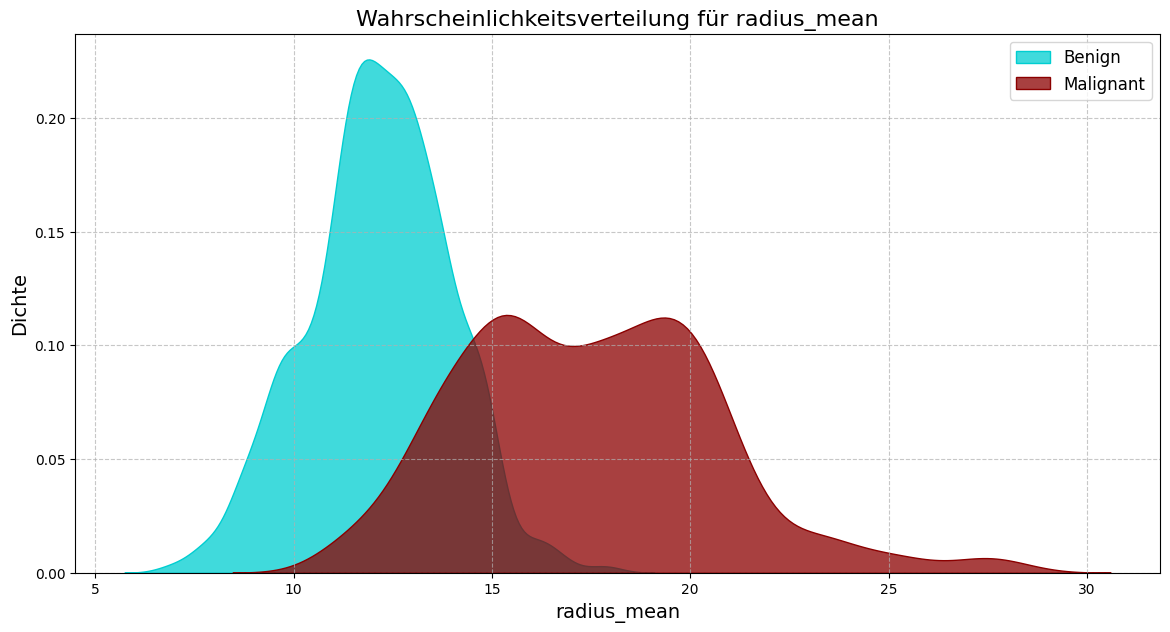

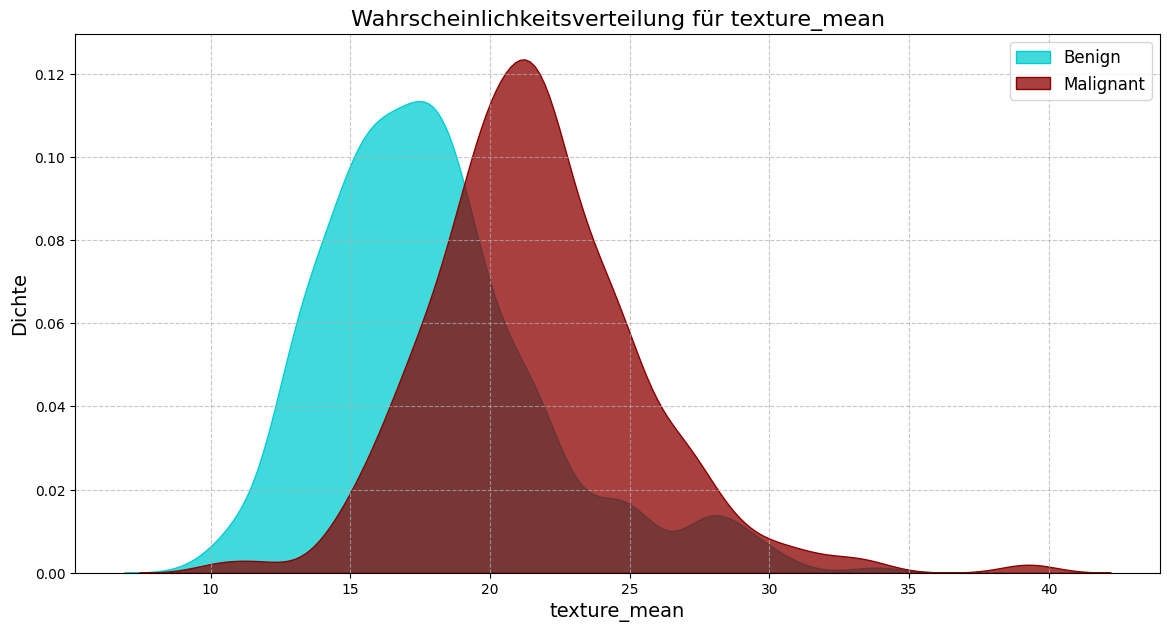

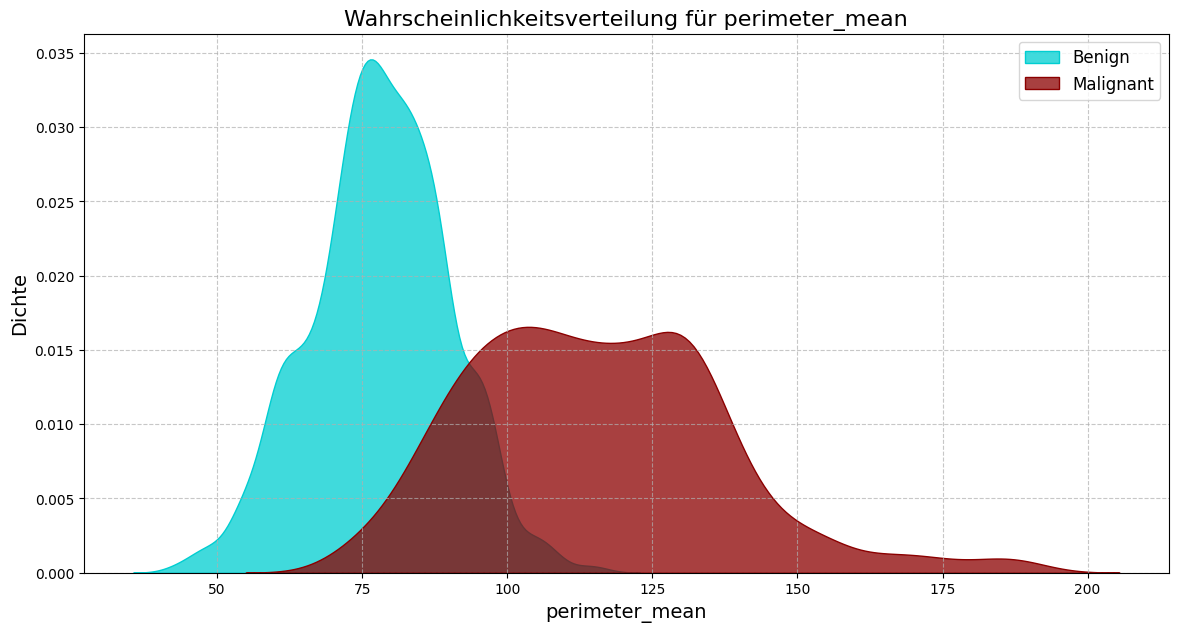

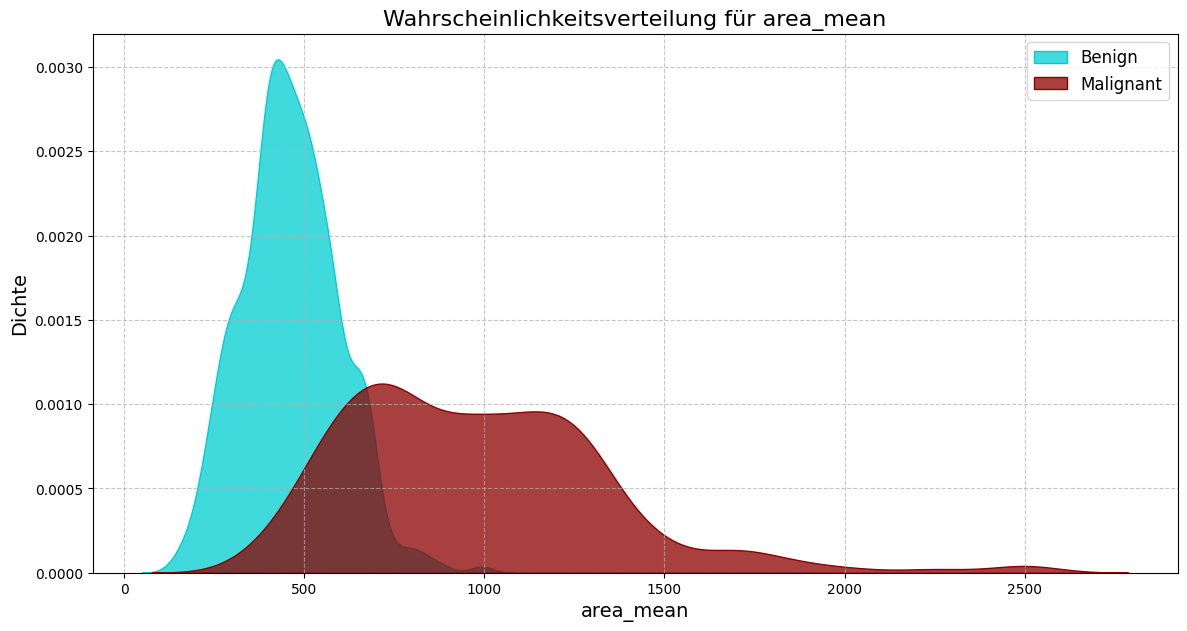

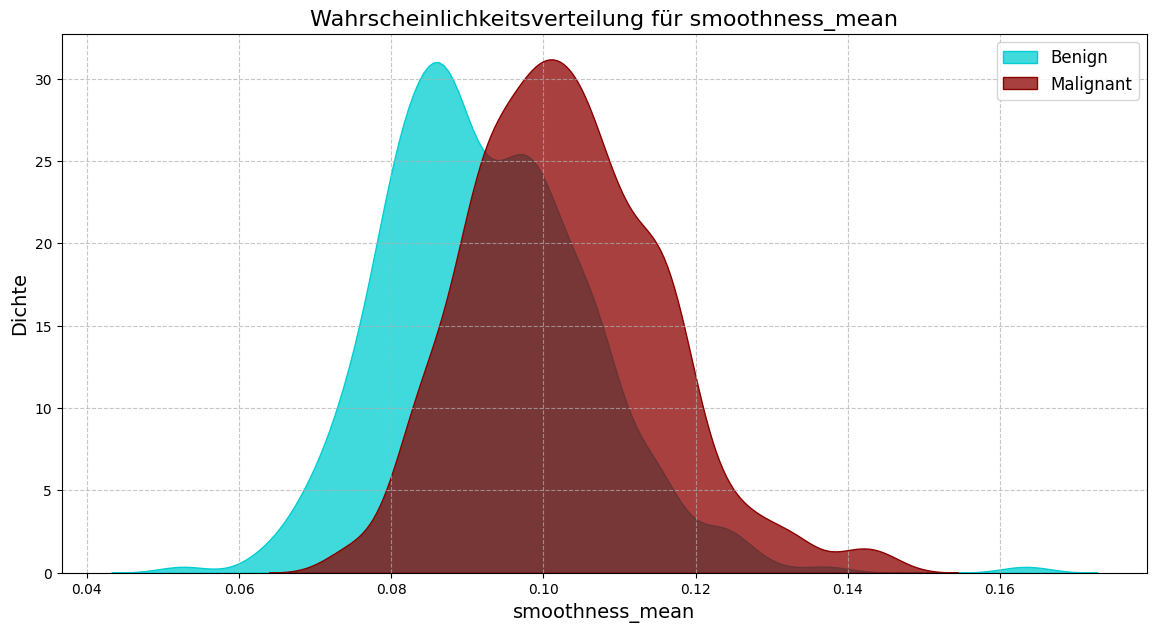

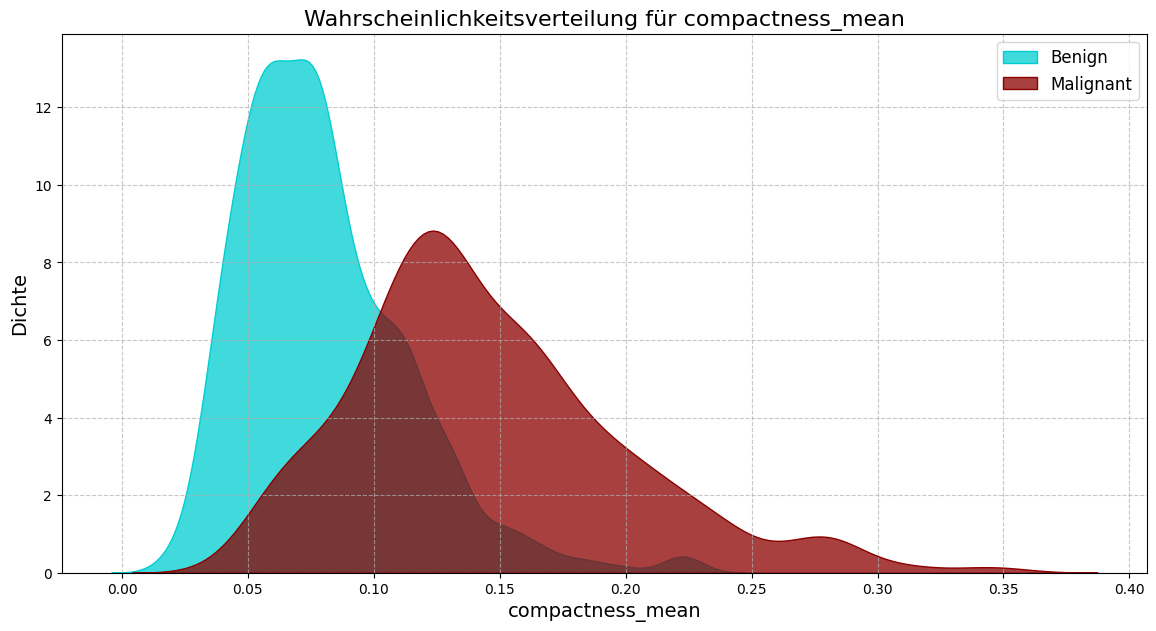

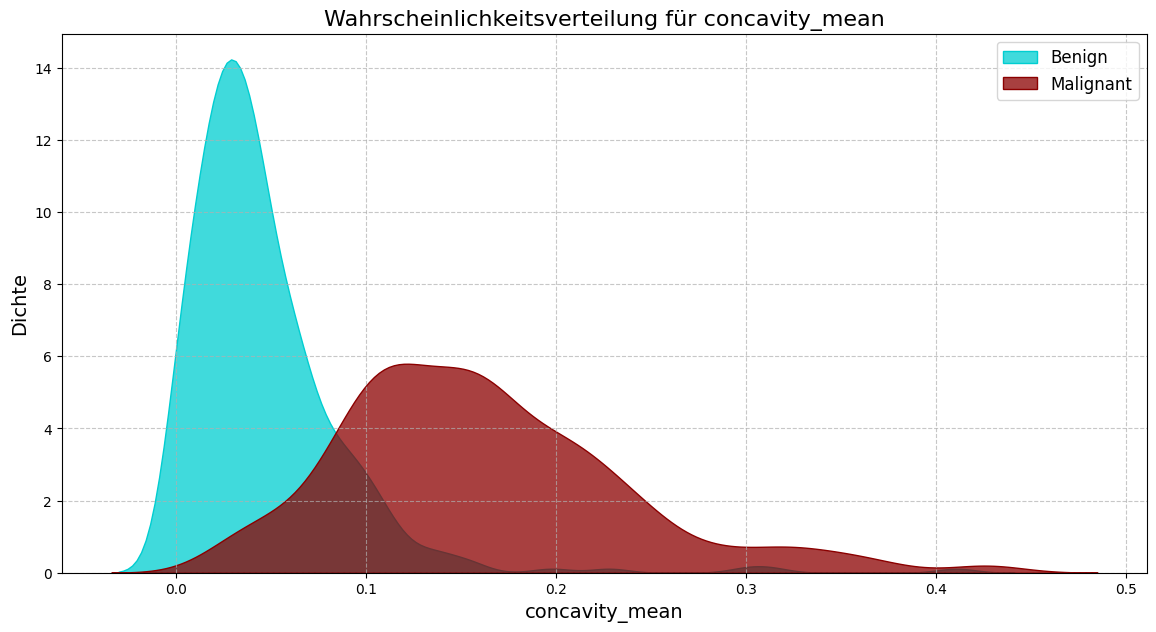

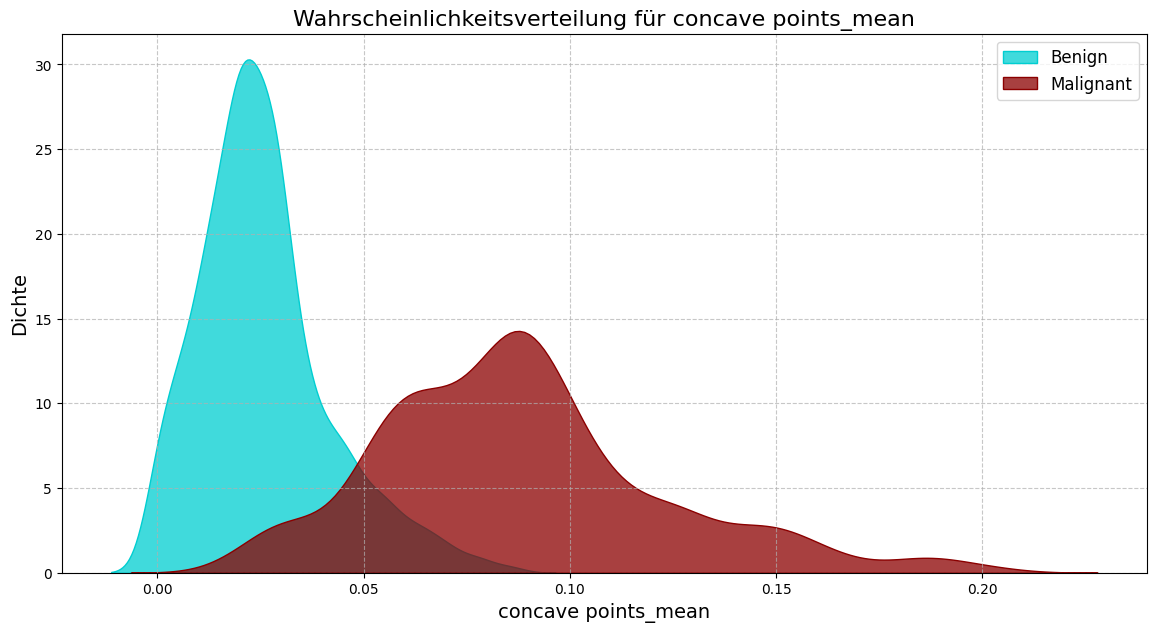

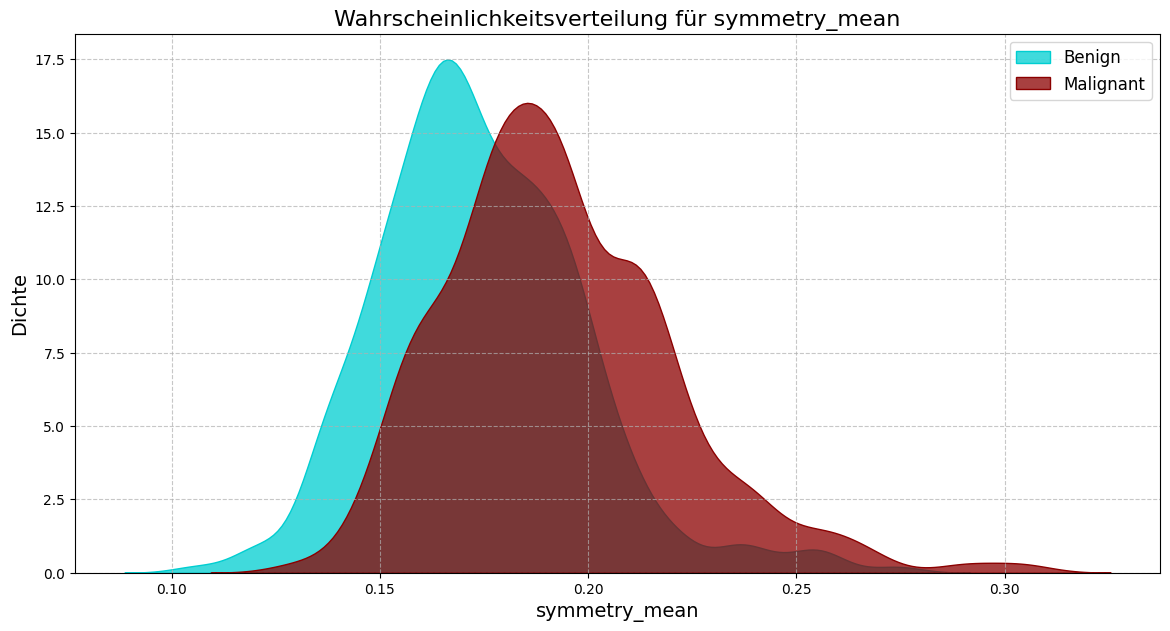

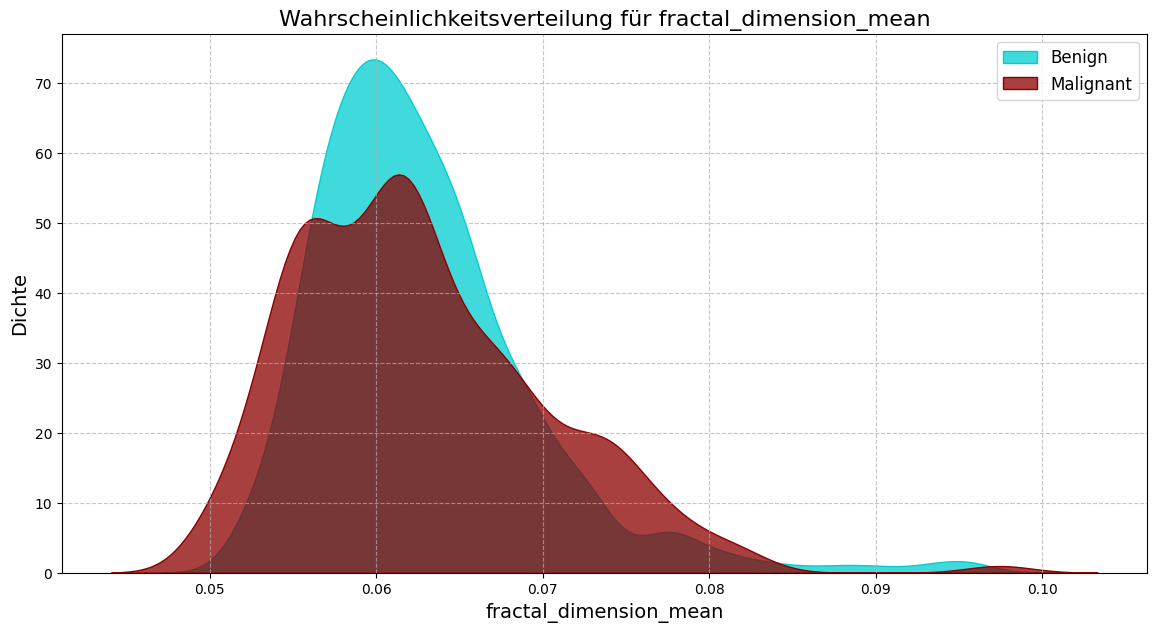

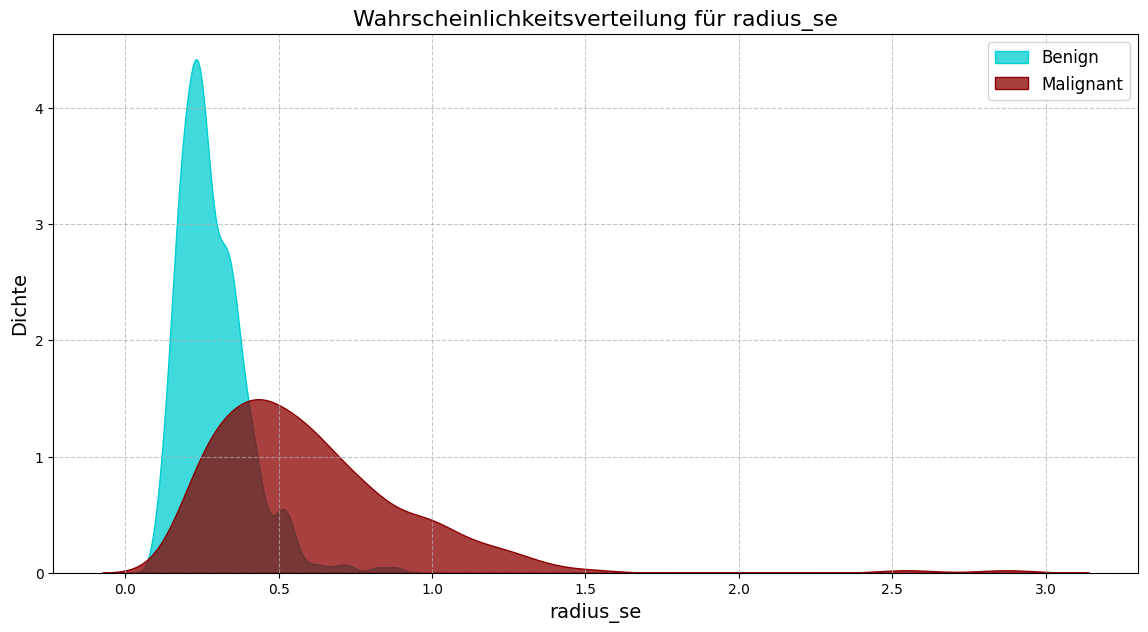

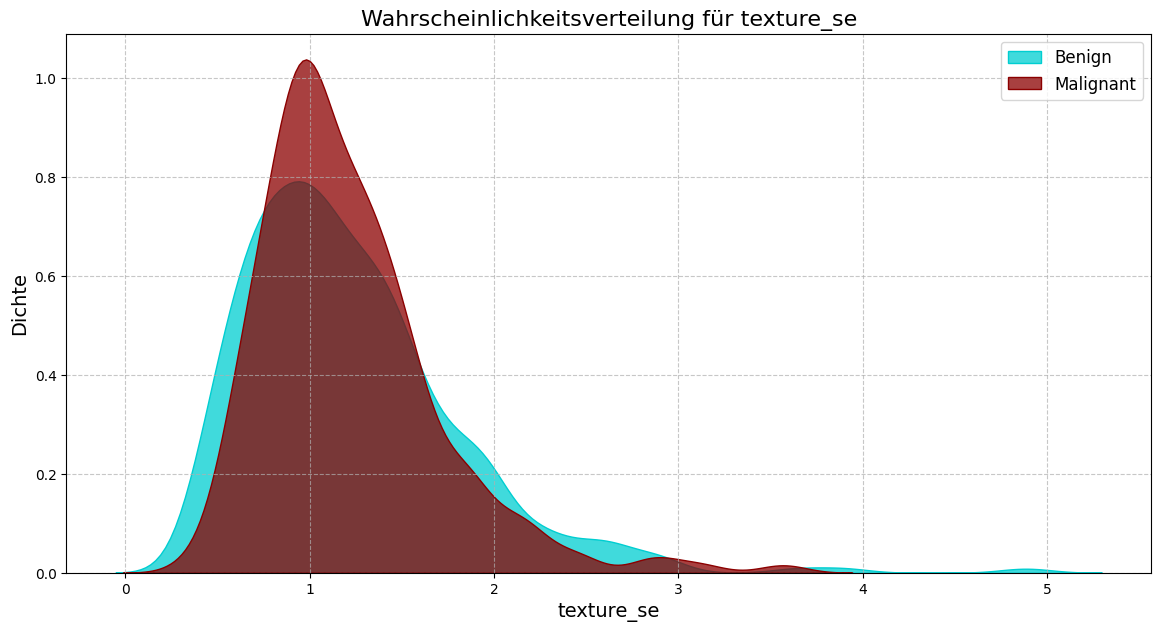

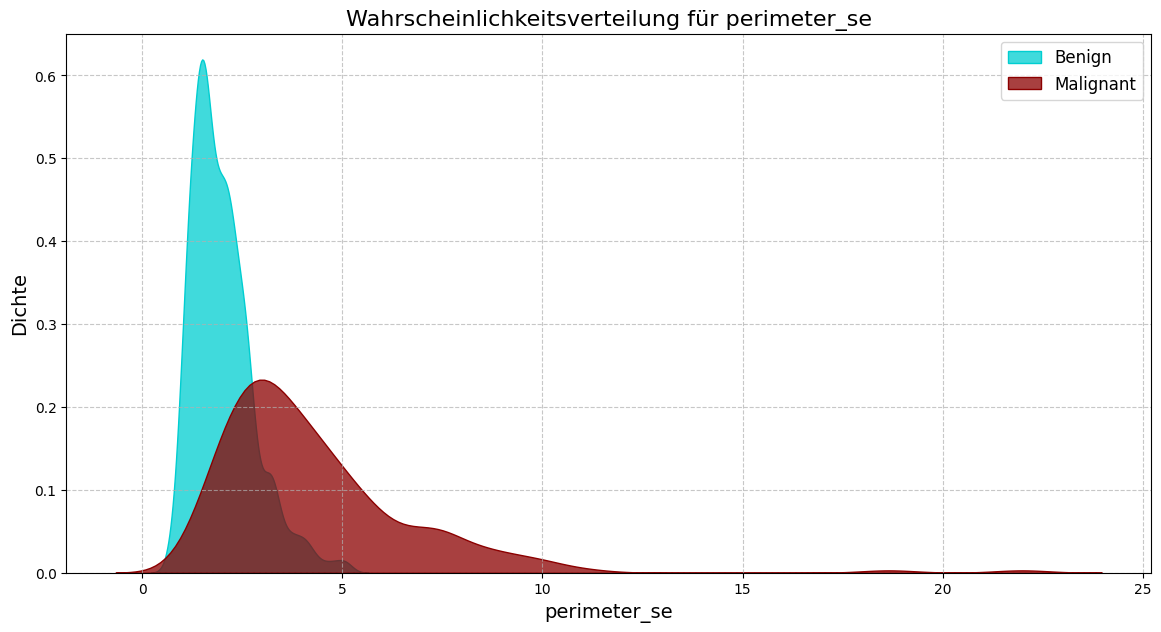

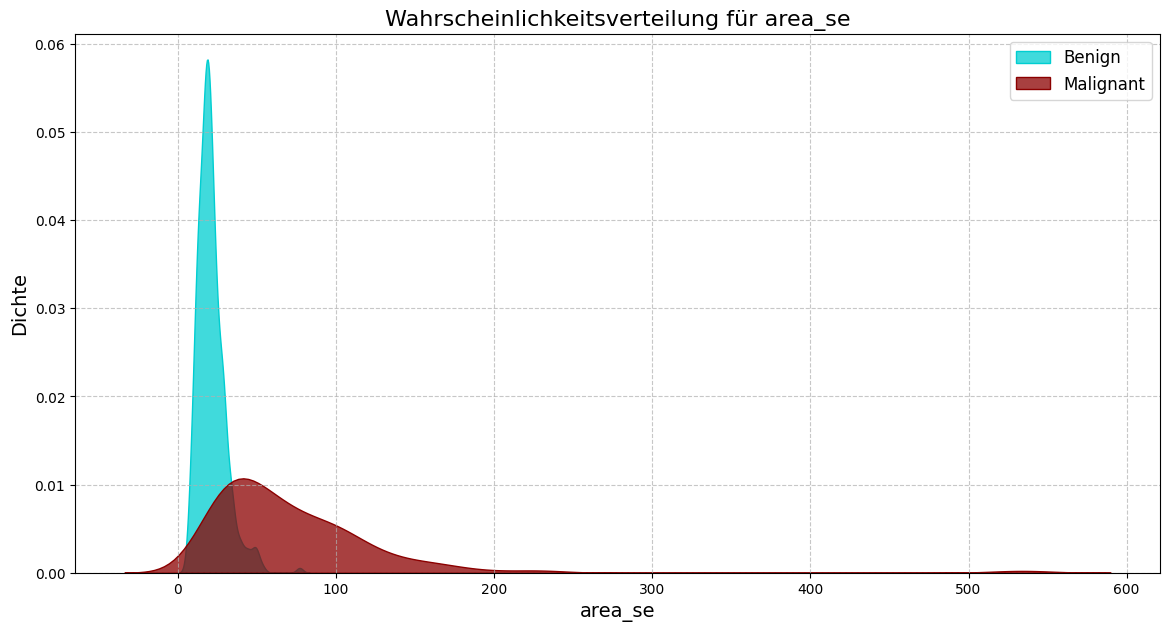

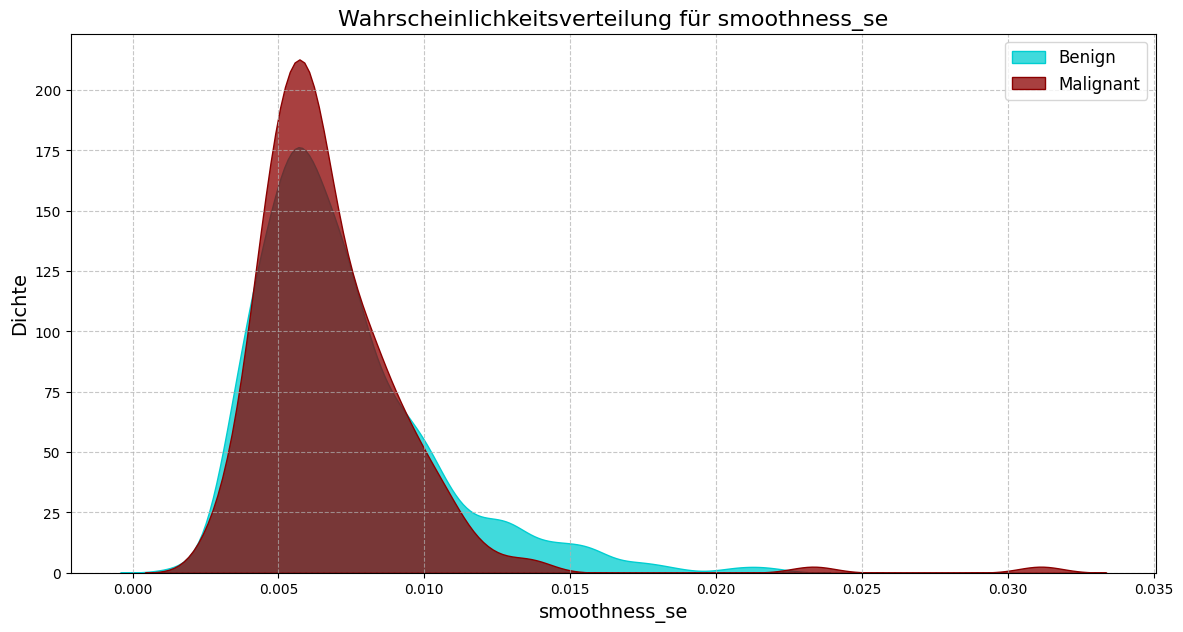

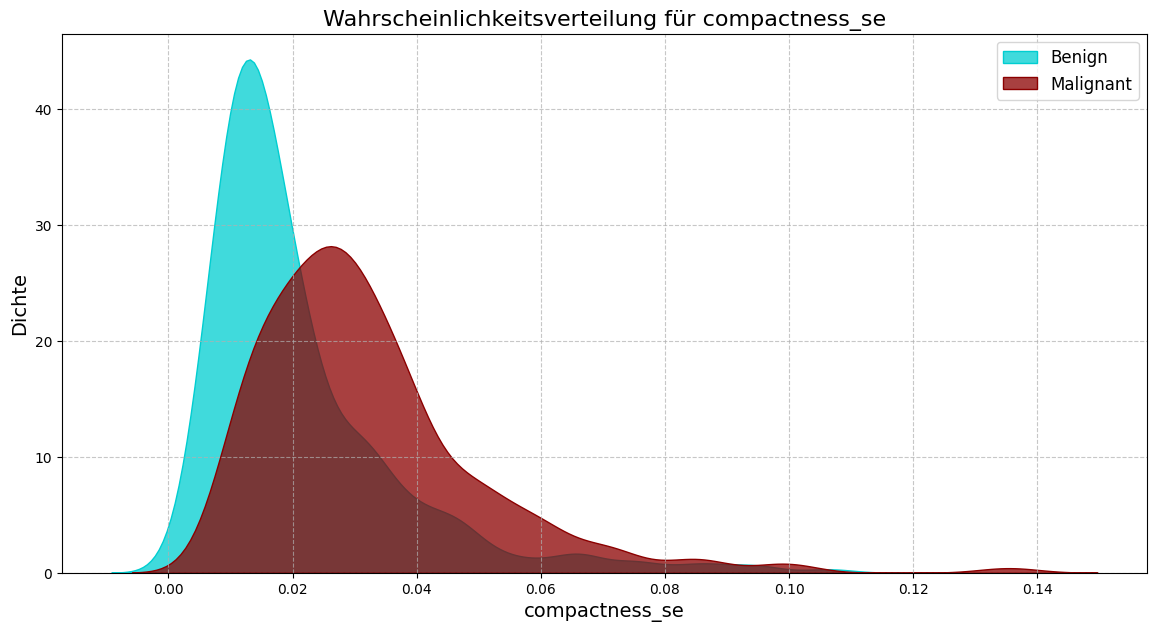

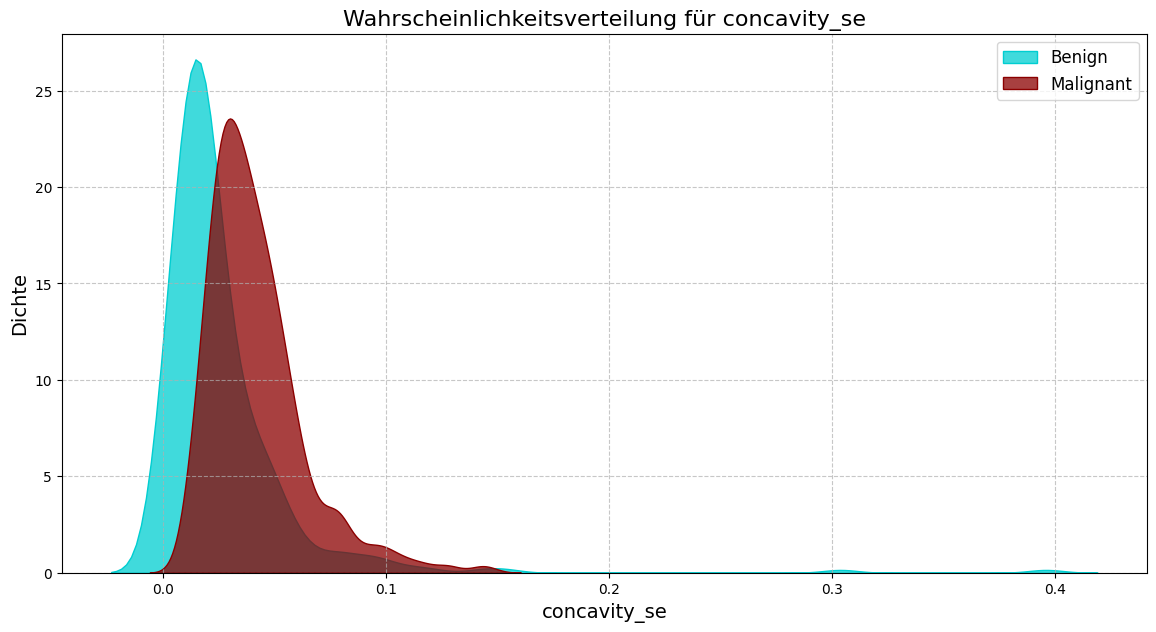

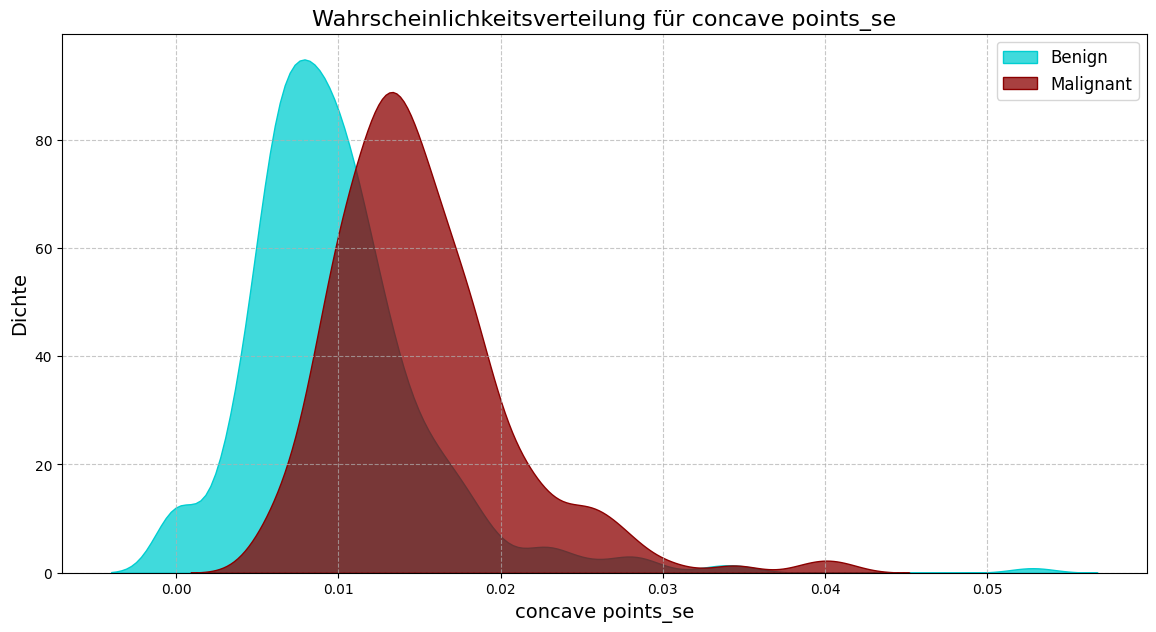

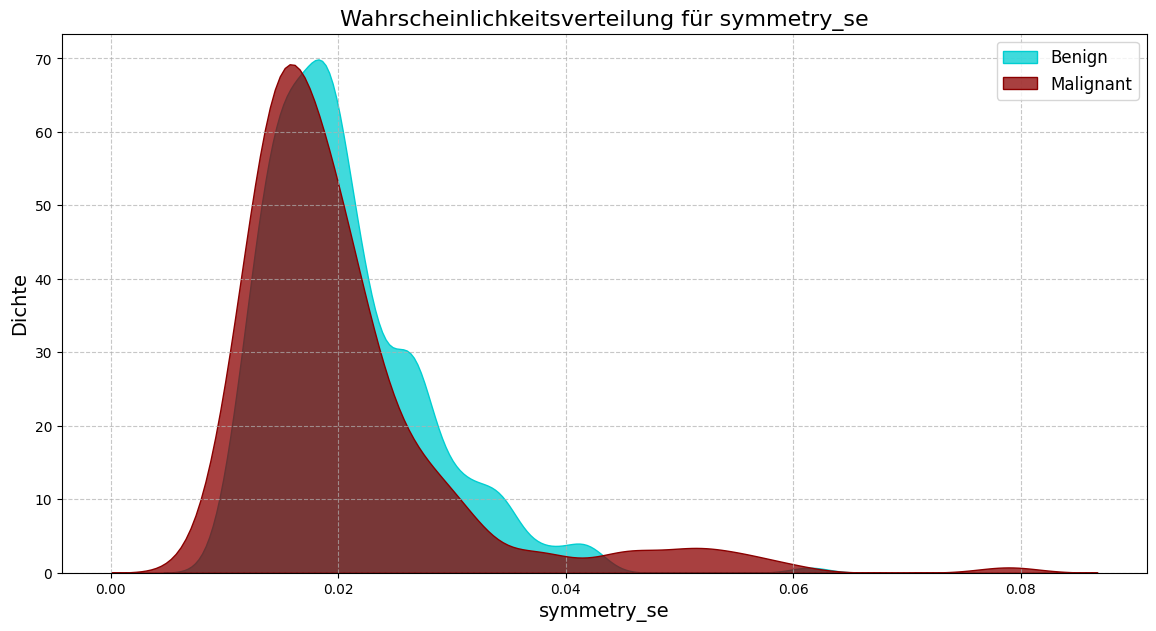

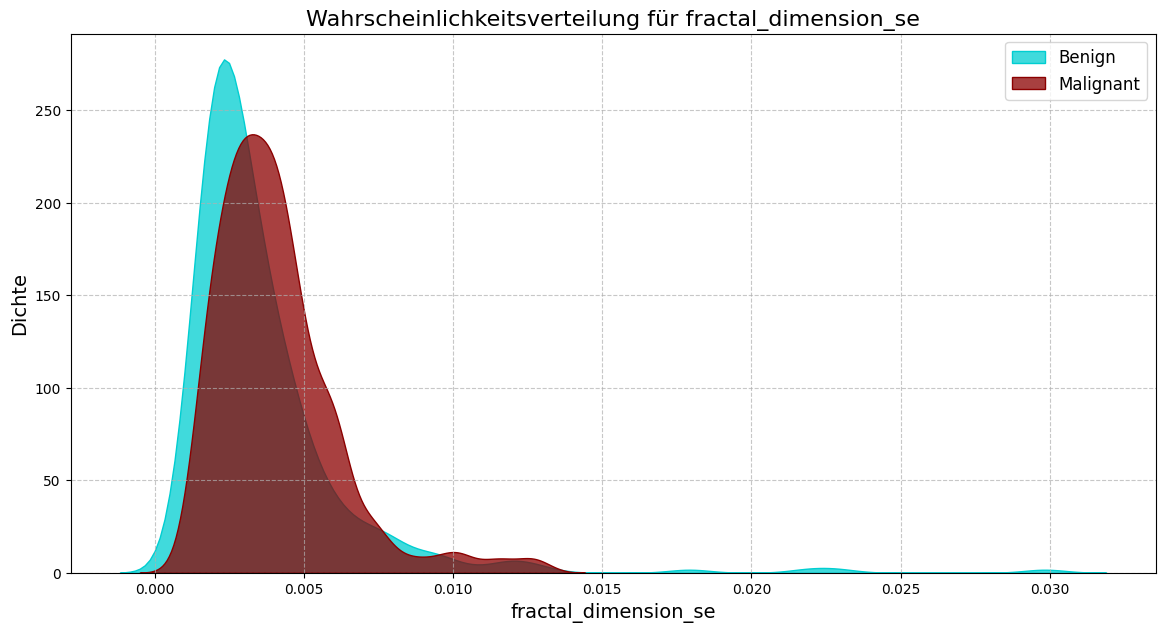

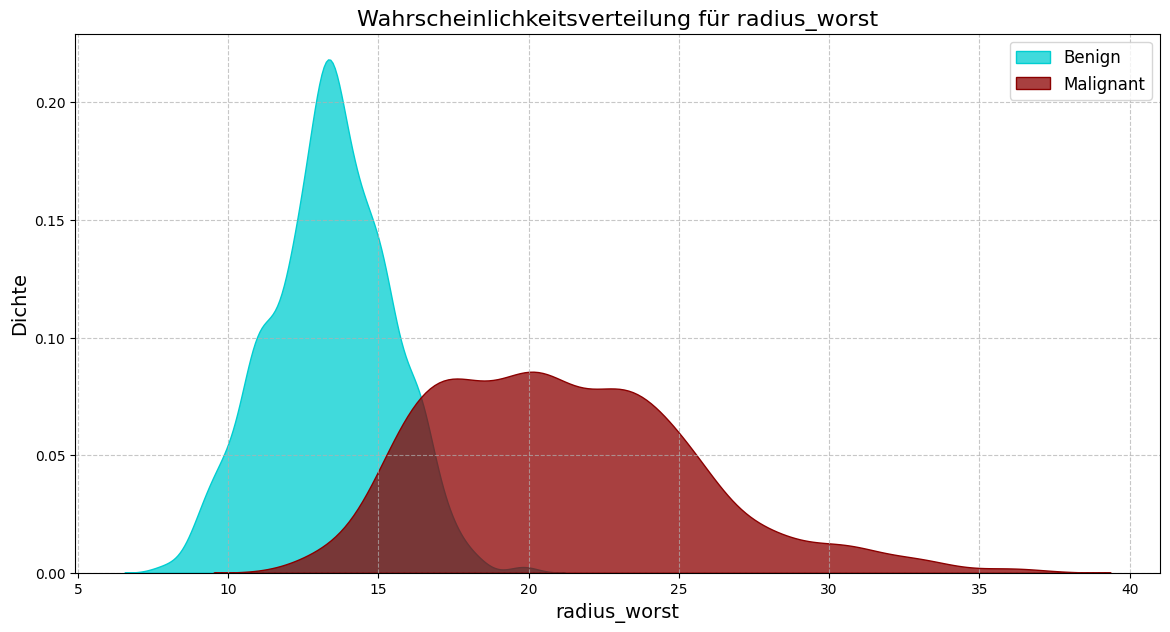

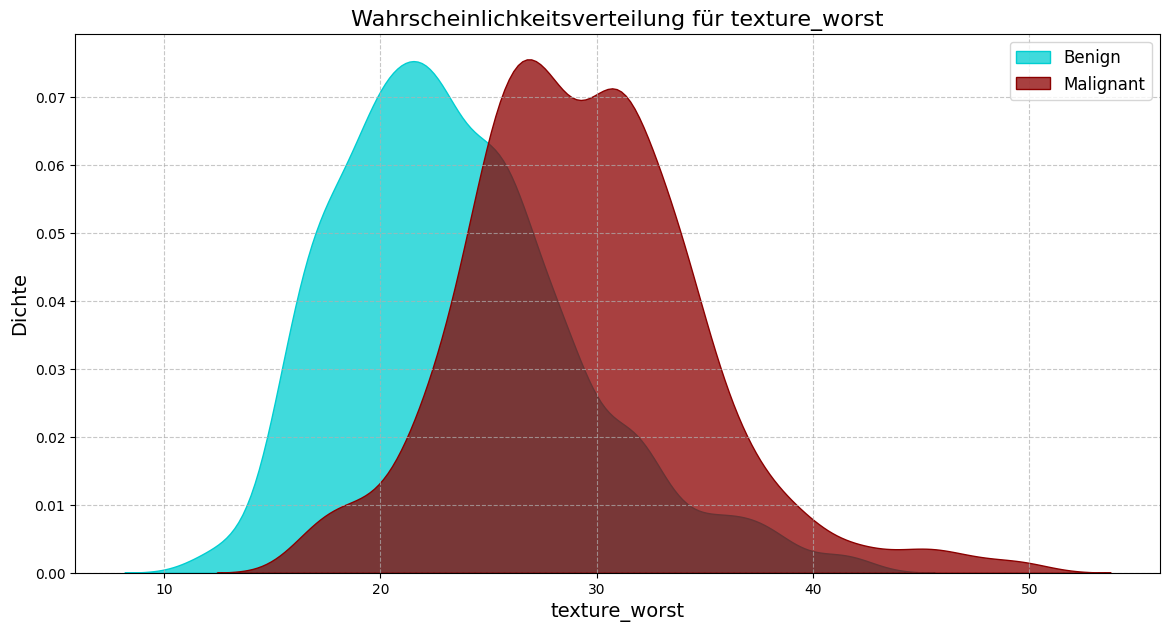

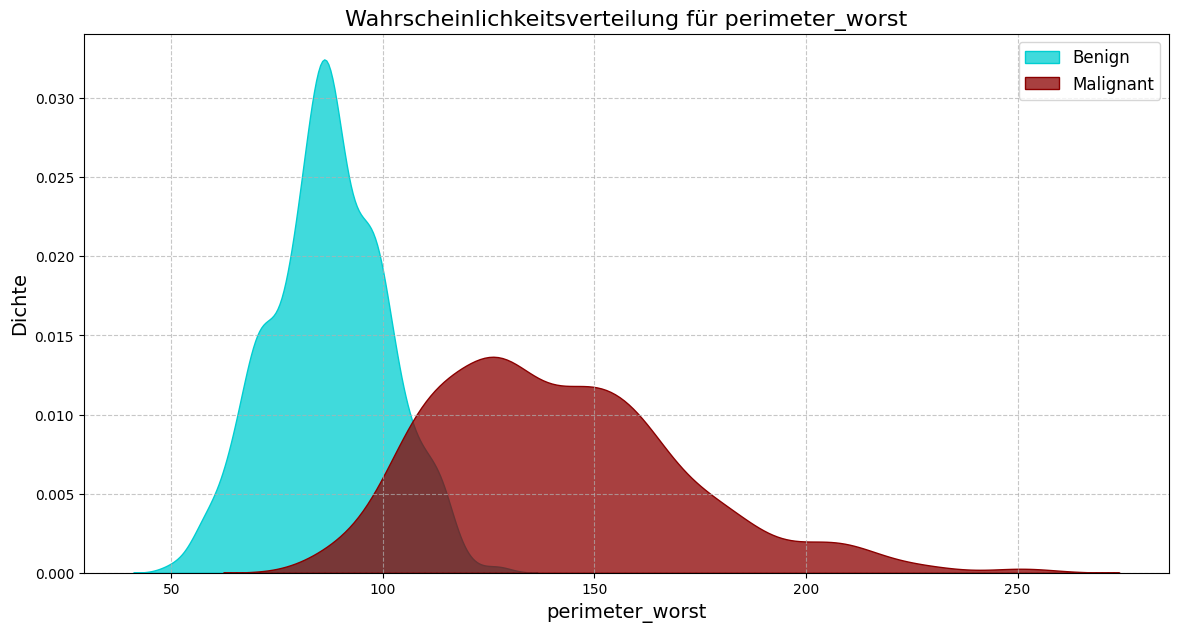

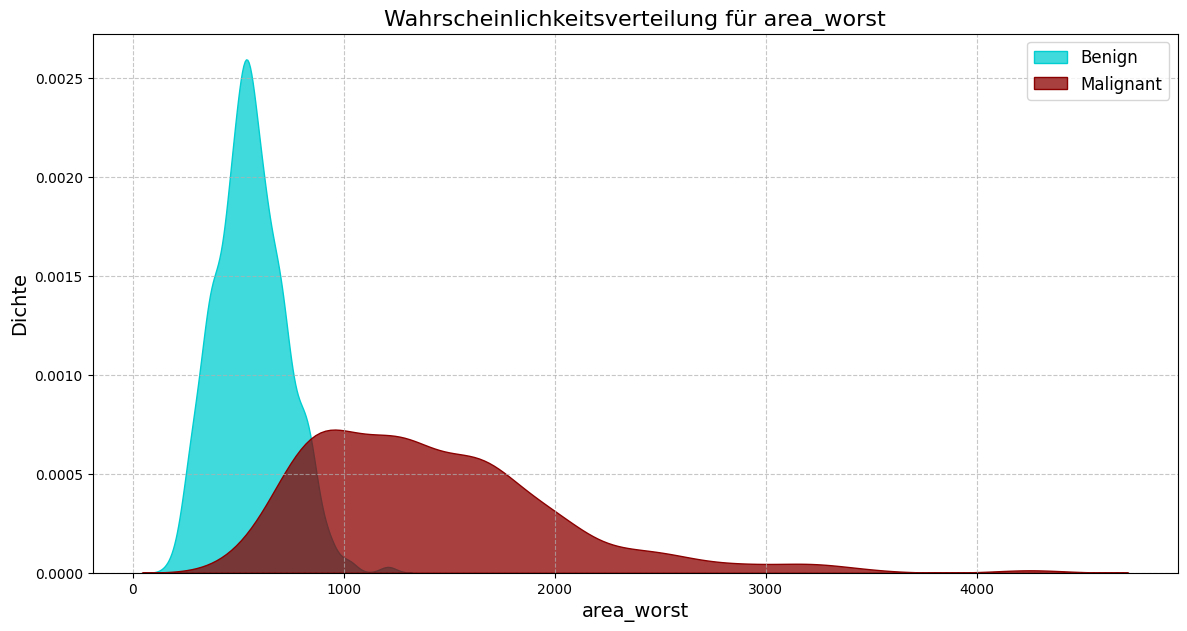

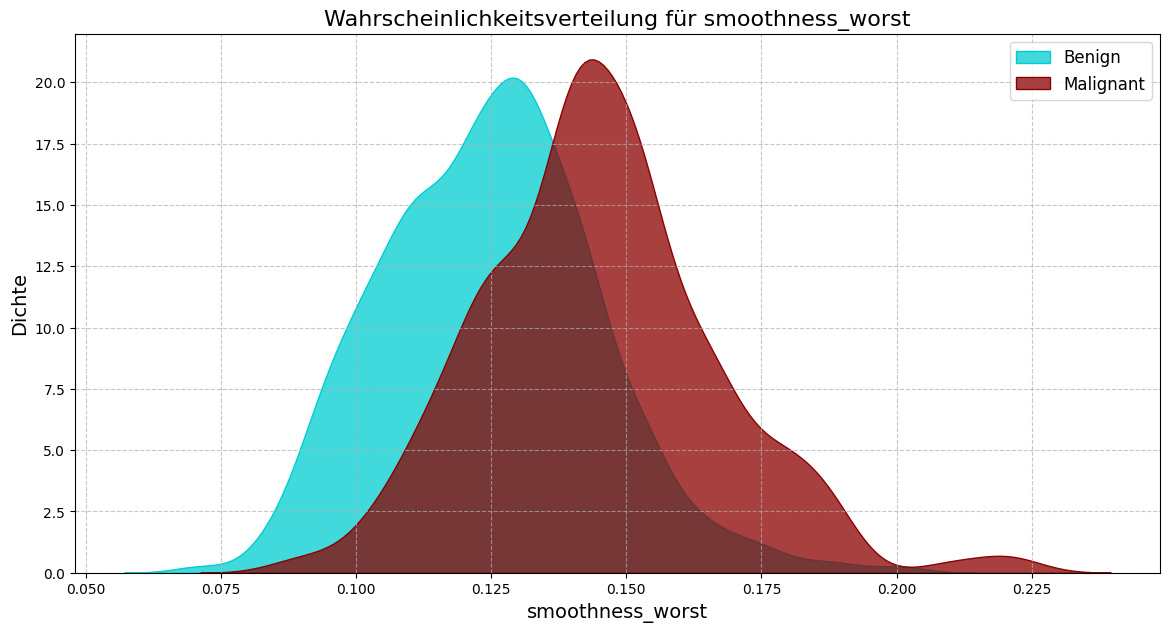

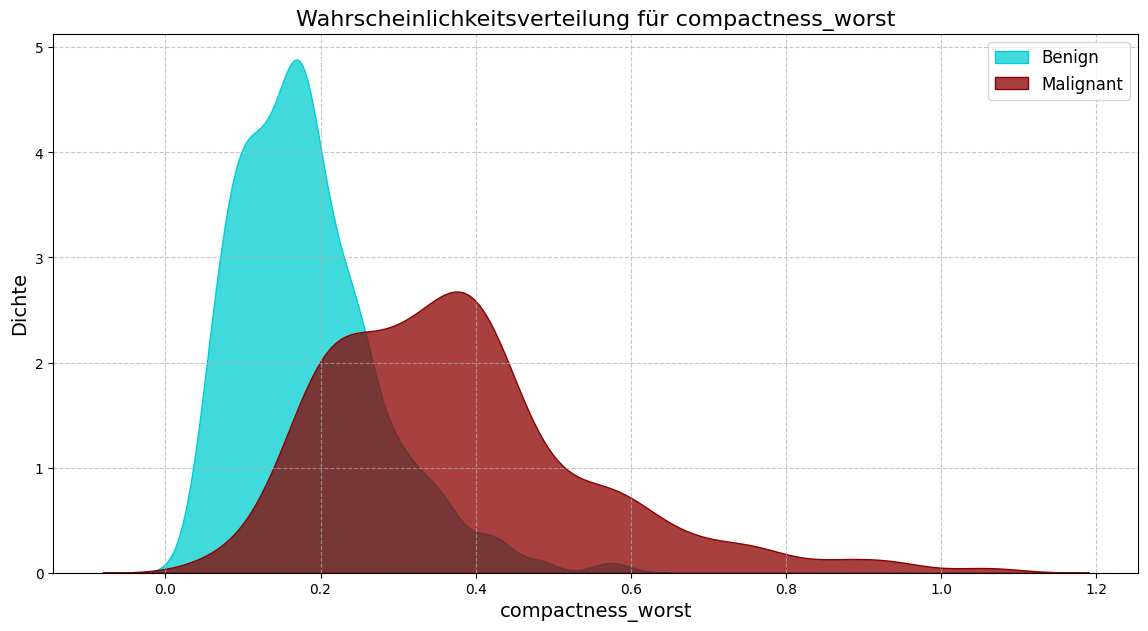

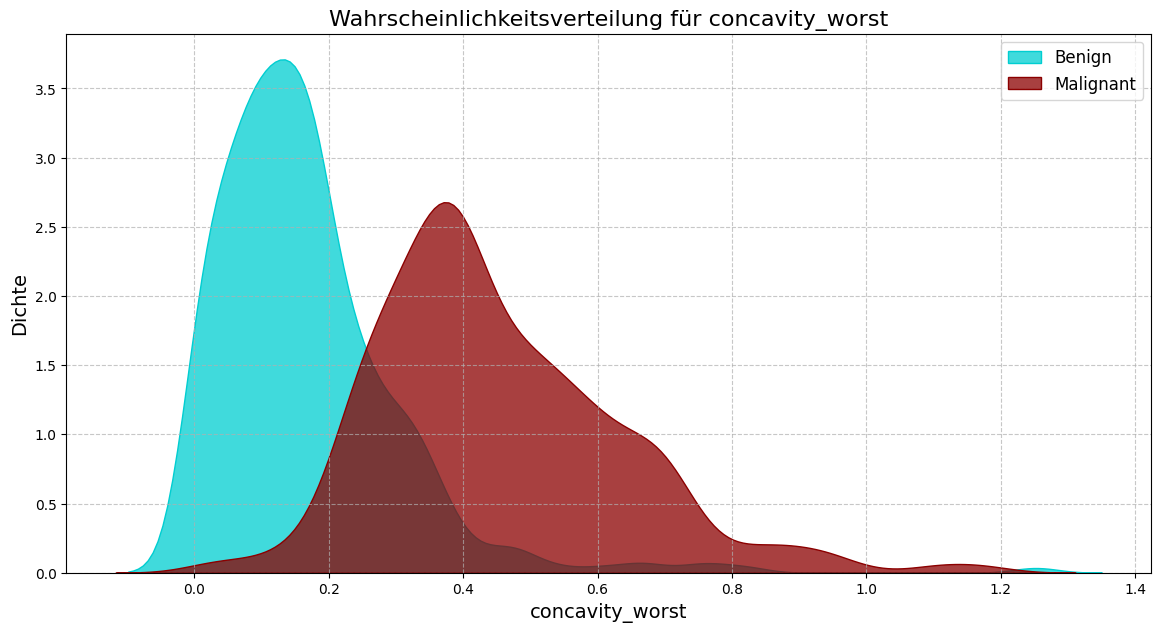

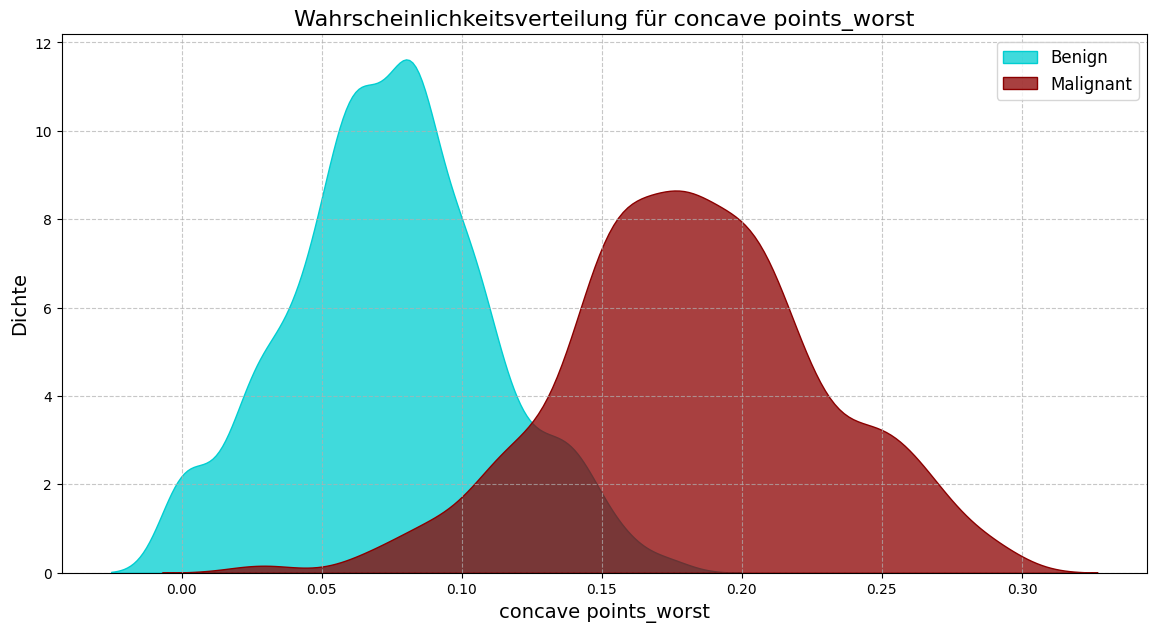

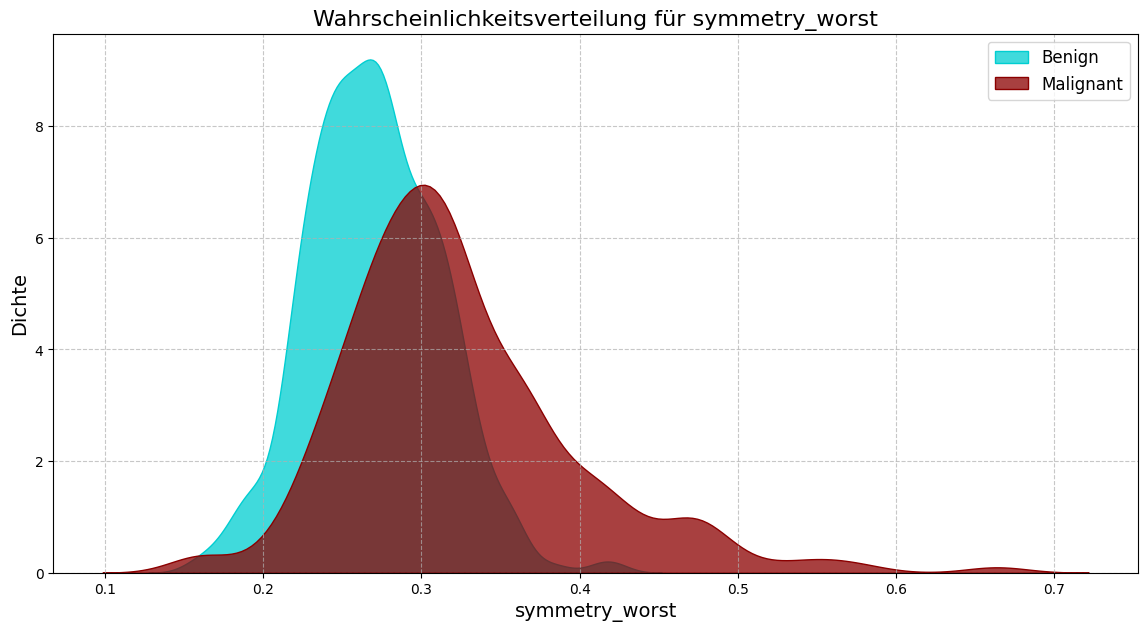

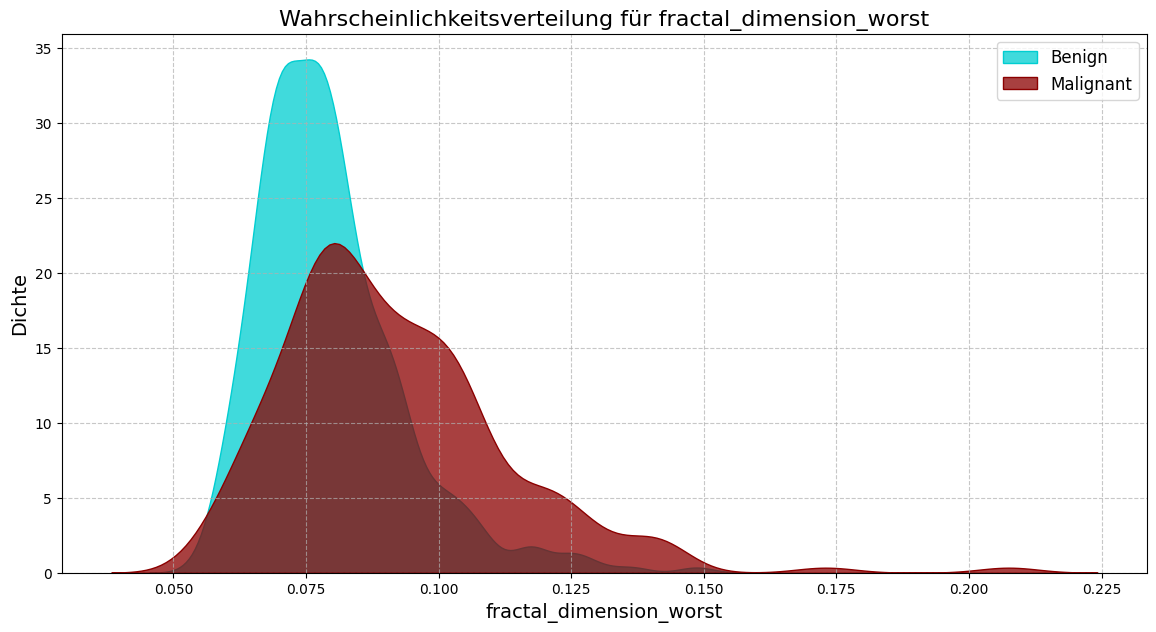

In [9]:
# Berechnung und Visualisierung der Verteilungen
for spalte in df.select_dtypes(include=[float, int]).columns:  # Numerische Spalten auswählen
    plt.figure(figsize=(14, 7))
        
    # Daten für 'Benign' und 'Malignant' extrahieren
    benign_data = df[df['diagnosis'] == 'Benign'][spalte]
    malignant_data = df[df['diagnosis'] == 'Malignant'][spalte]
        
    # Verteilung für 'Benign' und 'Malignant' plotten
    sns.kdeplot(benign_data, label='Benign', color=color_map['Benign'], fill=True, alpha=0.75)
    sns.kdeplot(malignant_data, label='Malignant', color=color_map['Malignant'], fill=True, alpha=0.75)
        
    # Titel und Achsenbeschriftungen
    plt.title(f'Wahrscheinlichkeitsverteilung für {spalte}', fontsize=16)
    plt.xlabel(spalte, fontsize=14)
    plt.ylabel('Dichte', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plot_path = os.path.join(output_folder_wahrscheinlichkeitsplots, f'wahrscheinlichkeit_{spalte}.png')
    plt.savefig(plot_path)
    plt.close()

    plt.show()